In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval

# Feature
from gensim.models import KeyedVectors

# Modeling
import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import legacy

# Time
import time
import datetime

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Membaca data
train_data = pd.read_csv('../../../../Data/5. Split/under/train_data_70_30_under.csv')
validation_data = pd.read_csv('../../../../Data/5. Split/under/validation_data_70_30_under.csv')
test_data = pd.read_csv('../../../../Data/5. Split/under/test_data_70_30_under.csv')

In [3]:
# Memisahkan fitur dan label untuk setiap bagian dataset
x_train = train_data['text_tokenize'].apply(literal_eval)
y_train = train_data.label

x_validation = validation_data['text_tokenize'].apply(literal_eval)
y_validation = validation_data.label

x_test = test_data['text_tokenize'].apply(literal_eval)
y_test = test_data.label

In [4]:
# Membuat tokenizer dengan jumlah kata maksimum
max_vocab = 7349
tokenizer = Tokenizer(num_words=max_vocab)

# Melatih tokenizer pada teks dari data latih
tokenizer.fit_on_texts(x_train)

# Mengonversi teks menjadi urutan bilangan bulat yang merepresentasikan indeks kata
sequences = tokenizer.texts_to_sequences(x_train)

In [5]:
length = []

# Menghitung jumlah kata dalam setiap teks dari data latih (x_train) dan menyimpannya dalam daftar length
for x in x_train:
    length.append(len(x))

# Menghitung jumlah kata maksimum dalam satu kalimat dari data latih (x_train)
max_word_count = max(length)

In [6]:
# Menetapkan panjang maksimum urutan (max_len) untuk padding
max_len = max_word_count

# Melakukan padding pada urutan data latih (x_train) agar memiliki panjang yang sama (max_len)
x_train_seq = pad_sequences(sequences, maxlen=max_len)

In [7]:
# Mengonversi teks dalam data validation (x_validation) menjadi urutan angka menggunakan tokenizer yang sama
sequences_val = tokenizer.texts_to_sequences(x_validation)

# Melakukan padding pada urutan data validasi agar memiliki panjang yang sama (max_len)
x_validation_seq = pad_sequences(sequences_val, maxlen=max_len)

In [8]:
# Menetapkan jumlah kata yang akan digunakan dalam matriks embedding
num_words = len(tokenizer.word_index) + 1

In [9]:
# Ubah label menjadi one-hot encoding
y_train_cat = to_categorical(y_train + 1, num_classes=3)
y_validation_cat = to_categorical(y_validation + 1, num_classes=3)

Pemodelan CNN-LSTM

In [10]:
# Setting learning rate within the Adam optimizer
Adam = legacy.Adam(learning_rate=0.001)

# Setting the label smoothing within the loss function
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

# Setting an Early_stopping callback to monitor accuracy with a patience degree of 3
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [11]:
model_cnnlstm = Sequential()

# Menambahkan layer Embedding dengan ukuran input yang sesuai
model_cnnlstm.add(Embedding(num_words, 300, input_length=max_len))

# Menambahkan layer Conv1D pertama dan MaxPooling1D
model_cnnlstm.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_cnnlstm.add(MaxPooling1D(pool_size=2))

# Menambahkan layer Conv1D kedua dan MaxPooling1D
model_cnnlstm.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_cnnlstm.add(MaxPooling1D(pool_size=2))

# Menambahkan layer LSTM dengan dropout dan recurrent_dropout
model_cnnlstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

# Menambahkan layer Dense output dengan aktivasi softmax untuk klasifikasi multi-kelas
model_cnnlstm.add(Dense(3, activation='softmax'))

# Mengkompilasi model dengan fungsi loss 'categorical_crossentropy', optimizer 'adam', dan metrik evaluasi 'accuracy'
model_cnnlstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Menampilkan ringkasan model
model_cnnlstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 399, 300)          1182300   
                                                                 
 conv1d (Conv1D)             (None, 399, 32)           28832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 199, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 199, 32)           3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 32)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               5

In [12]:
# Melatih model menggunakan data latihan dan validasi
history_model = model_cnnlstm.fit(x_train_seq, y_train_cat, validation_data=(x_validation_seq, y_validation_cat), epochs=10, batch_size=128, callbacks=[callback], verbose=2)

Epoch 1/10
15/15 - 10s - loss: 1.0949 - accuracy: 0.3975 - val_loss: 1.0805 - val_accuracy: 0.5123 - 10s/epoch - 657ms/step
Epoch 2/10
15/15 - 7s - loss: 1.0297 - accuracy: 0.5394 - val_loss: 0.9670 - val_accuracy: 0.4951 - 7s/epoch - 436ms/step
Epoch 3/10
15/15 - 6s - loss: 0.8216 - accuracy: 0.6456 - val_loss: 0.8194 - val_accuracy: 0.6446 - 6s/epoch - 408ms/step
Epoch 4/10
15/15 - 6s - loss: 0.5841 - accuracy: 0.7734 - val_loss: 0.7970 - val_accuracy: 0.7034 - 6s/epoch - 411ms/step
Epoch 5/10
15/15 - 6s - loss: 0.3726 - accuracy: 0.8733 - val_loss: 0.8765 - val_accuracy: 0.6936 - 6s/epoch - 414ms/step
Epoch 6/10
15/15 - 6s - loss: 0.2339 - accuracy: 0.9206 - val_loss: 1.0245 - val_accuracy: 0.6887 - 6s/epoch - 429ms/step
Epoch 7/10
15/15 - 6s - loss: 0.1534 - accuracy: 0.9506 - val_loss: 1.0812 - val_accuracy: 0.6863 - 6s/epoch - 416ms/step


Evaluasi Pemodelan CNN-LSTM

In [13]:
model_eval = model_cnnlstm.evaluate(x_validation_seq, y_validation_cat, verbose=0)
print("Akurasi validasi model: {:.2f}%".format(model_eval[1] * 100))

Akurasi validasi model: 70.34%


In [14]:
# Fungsi date_time
def date_time(x):
    # Jika x == 1, kembalikan timestamp dengan format 'YYYY-MM-DD HH:MM:SS'
    if x == 1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    # Jika x == 2, kembalikan timestamp dengan format 'YYYY-Mon-DD HH:MM:SS'
    if x == 2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    # Jika x == 3, kembalikan tanggal dan waktu sekarang
    if x == 3:  
        return 'Date now: %s' % datetime.datetime.now()
    # Jika x == 4, kembalikan tanggal sekarangang
    if x == 4:  
        return 'Date today: %s' % datetime.date.today()

In [15]:
def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    # Atur label sumbu x dan legenda
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    # Buat gambar dengan ukuran yang ditentukan
    plt.figure(figsize=(20, 5))

    # Dapatkan nilai akurasi dari history
    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    # Hitung batas bawah dan atas untuk sumbu y (akurasi)
    min_y = min(min(y1), min(y2)) - ylim_pad[0]
    max_y = max(max(y1), max(y2)) + ylim_pad[0]

    # Buat subplot untuk akurasi (1 baris, 2 kolom, posisi 1)
    plt.subplot(121)

    # Plot akurasi pelatihan dan validasi
    plt.plot(y1)
    plt.plot(y2)

    # Atur judul, label, legenda, dan grid untuk subplot akurasi
    plt.title('Model Accuracy\n' + date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    # Dapatkan nilai loss dari history
    y1 = history.history['loss']
    y2 = history.history['val_loss']

    # Hitung batas bawah dan atas untuk sumbu y (loss)
    min_y = min(min(y1), min(y2)) - ylim_pad[1]
    max_y = max(max(y1), max(y2)) + ylim_pad[1]

    # Buat subplot untuk loss (1 baris, 2 kolom, posisi 2)
    plt.subplot(122)

    # Plot loss pelatihan dan validasi
    plt.plot(y1)
    plt.plot(y2)

    # Atur judul, label, legenda, dan grid untuk subplot loss
    plt.title('Model Loss\n' + date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    # Simpan gambar jika figure_directory diberikan
    if figure_directory:
        plt.savefig(figure_directory + "/history")

    # Tampilkan plot
    plt.show()

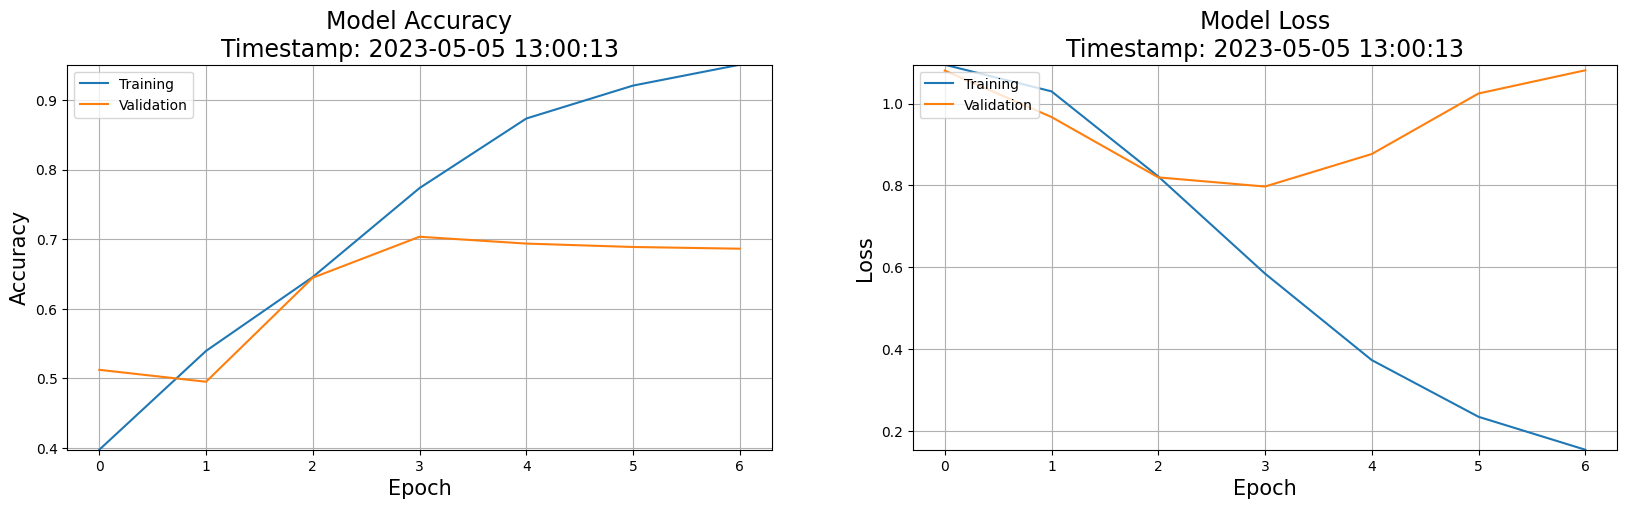

In [16]:
# Panggil fungsi plot_performance dengan history dari model terbaik
plot_performance(history=history_model)

In [17]:
# Mengkonversi teks dalam x_test menjadi urutan token dengan tokenizer
sequences_test = tokenizer.texts_to_sequences(x_test)

# Melakukan padding pada urutan token agar memiliki panjang yang sama
x_test_seq = pad_sequences(sequences_test, maxlen=max_len)

# Mengubah label y_test menjadi bentuk one-hot encoding
y_test_cat = to_categorical(y_test + 1, num_classes=3) 

In [18]:
# Menilai model CNN-LSTM yang telah dilatih menggunakan data test (x_test_seq dan y_test_cat)
CNNLSTM_model_evaluation = model_cnnlstm.evaluate(x=x_test_seq, y=y_test_cat)

# Memprediksi label kelas menggunakan model CNN-LSTM yang telah dilatih pada data test (x_test_seq)
yhat_cnnlstm = model_cnnlstm.predict(x_test_seq)

13/13 [==============================] - 3s 35ms/step


In [19]:
# Mengkonversi prediksi probabilitas ke label kelas untuk kedua model
y_pred_cnnlstm = np.argmax(yhat_cnnlstm, axis=1) - 1

# Menghitung true label dari one-hot encoding
y_true = np.argmax(y_test_cat, axis=1) - 1

In [20]:
# Menampilkan classification report untuk kedua model
print("Classification Report (CNN-LSTM Model):")
print(classification_report(y_true, y_pred_cnnlstm))

Classification Report (CNN-LSTM Model):
              precision    recall  f1-score   support

          -1       0.69      0.55      0.61       136
           0       0.55      0.65      0.60       136
           1       0.79      0.79      0.79       136

    accuracy                           0.67       408
   macro avg       0.68      0.67      0.67       408
weighted avg       0.68      0.67      0.67       408



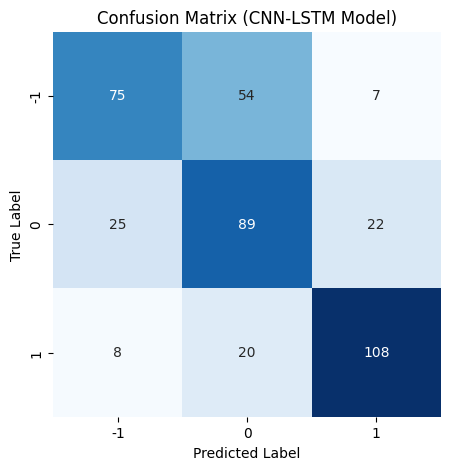

In [21]:
# Menghitung confusion matrix untuk kedua model
cm_lstm = confusion_matrix(y_true, y_pred_cnnlstm)

# Fungsi untuk visualisasi confusion matrix
def plot_cm(cm, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xticks([0.5, 1.5, 2.5], ['-1', '0', '1'])
    plt.yticks([0.5, 1.5, 2.5], ['-1', '0', '1'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Menampilkan visualisasi confusion matrix untuk kedua model
plot_cm(cm_lstm, "Confusion Matrix (CNN-LSTM Model)")

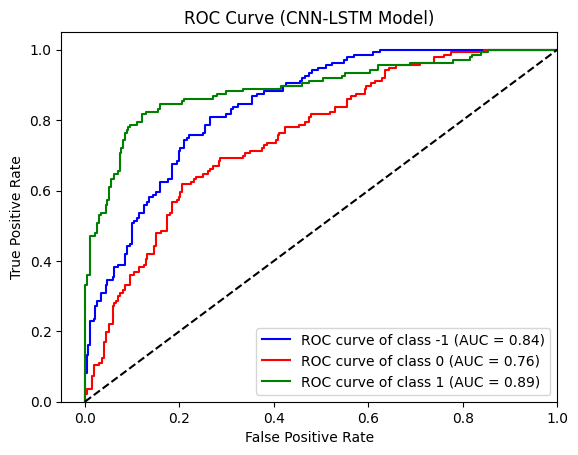

In [22]:
# Fungsi untuk menggambarkan ROC curve
def plot_roc_curve(y_true, y_score, n_classes, title):
    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=[-1, 0, 1])

    # Menghitung ROC curve dan AUC untuk setiap kelas
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Menggambarkan ROC curve
    plt.figure()
    colors = ['blue', 'red', 'green']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(i-1, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Menggambarkan ROC curve untuk kedua model
plot_roc_curve(y_true, yhat_cnnlstm, n_classes=3, title='ROC Curve (CNN-LSTM Model)')

Output

In [23]:
# Panggil dataset
full_data = pd.read_csv('../../../../Data/3. EDA/clean-eda_.csv')

# Prediksi pada keseluruhan data
sequences_full = tokenizer.texts_to_sequences(full_data['text'])
x_full_seq = pad_sequences(sequences_full, maxlen=max_len)
yhat_full_cnn= model_cnnlstm.predict(x_full_seq)

# Konversi prediksi ke label kelas
yhat_full_cnn_classes = np.argmax(yhat_full_cnn, axis=1) - 1

# Tambahkan kolom baru ke DataFrame
full_data['predicted_sentiment'] = yhat_full_cnn_classes

full_data.head(10)

150/150 [==============================] - 7s 46ms/step


,video_id,raw,text,predicted_sentiment
0,video1,Baiknya bagaimana menurut kalian?,baik bagaimana turut kalian,0
1,video1,Betul dok betul dok,betul dok betul dok,0
2,video1,Betul dok mungkin efek sa di,betul dok mungkin efek sa,0
3,video1,"Bpom aneh, tidak kerja. Kenapa ko seperti itu.",bpom aneh kerja kok itu,-1
4,video1,Benar banget anak sy aj hrs sirup minum obatny...,benar banget anak aku saja harus sirup minum o...,1
5,video1,Makasih ilmunya dokter semoga berkah🥰🥰🥰🥰,terima kasih ilmu dokter semoga berkah,1
6,video1,Dok tempra gimana? Soalnya anakku kalau demam ...,dok tempra bagaimana soal anak kalau demam kas...,0
7,video1,BIOSOLFON KIDS AMAN GAK KAK,biosolfon kids aman enggak kak,0
8,video1,apa kurang ilmu ya dok,apa kurang ilmu dok,0
9,video1,Cara media massa cari uang.... Memainkan keres...,cara media massa cari uang main resah bingung ...,-1


In [24]:
#full_data.to_csv("./../../Data/6. Prediksi/submission-LSTM.csv", index=False)